In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from skimage.feature import hog
import glob
from scipy.ndimage.measurements import label
%matplotlib inline
print("done")

done


In [2]:
#Import data
def load_data(data_dir):
    images = []
    for f in os.listdir(data_dir):
        im = cv2.imread(os.path.join(data_dir, f))
        if im is not None:
            images.append(im)
    return images

# Divide up into cars and notcars
cars_path = []
cars_path = glob.glob('vehicles/*/*.png')
cars = []
notcars_path = []
notcars_path = glob.glob('non-vehicles/*/*.png')
notcars = []
for car_path in cars_path:
    if car_path is not None:
        cars.append(cv2.imread(car_path))
cars = np.array(cars)        
for notcar_path in notcars_path:
    if notcar_path is not None:
        notcars.append(cv2.imread(notcar_path))
notcars = np.array(notcars) 

#load test images
test_images_dir= "CarND-Vehicle-Detection-master/test_images"
test_images = load_data(test_images_dir)
test_images = np.array(test_images)

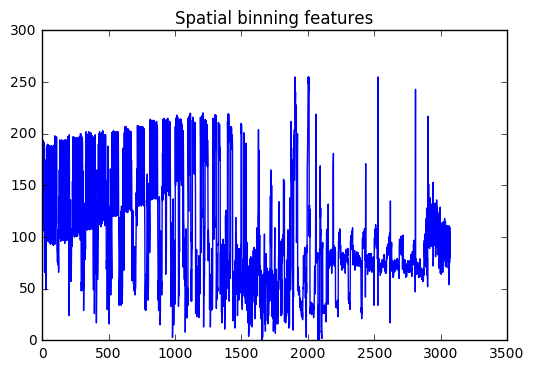

In [60]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features
i=5
bin_size = (32,32)
plt.plot(bin_spatial(test_images[i],bin_size))
plt.title('Spatial binning features')

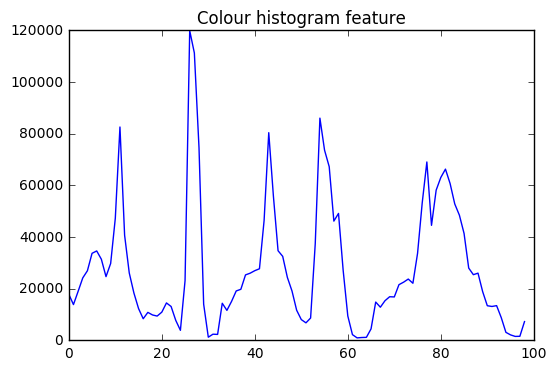

In [62]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
i = 3
nbins = 33
bins_range = (0,256)
plt.plot(color_hist(test_images[i],nbins,bins_range))
plt.title('Colour histogram feature')

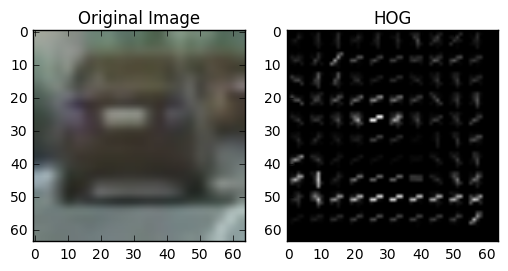

In [59]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
i = 0
orient = 9
pix_per_cell = 6
cell_per_block = 2
gray = cv2.cvtColor(cars[i], cv2.COLOR_RGB2GRAY)
features,hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
#fig = plt.figure(figsize=(17,17))
plt.subplot(121)
plt.imshow(cars[i])
plt.title('Original Image')
plt.subplot(122)
plt.imshow(hog_image,cmap='gray')
plt.title('HOG')

In [33]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='gray',
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        img_features = []
        # Read in each one by one
        #image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            img_features.append(spatial_features)
        # Apply color_hist() also with a color space option now
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            img_features.append(hist_features)
        #Apply get_hog_features()
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
            elif hog_channel == 'gray':
                hog_features = get_hog_features(cv2.cvtColor(feature_image,cv2.COLOR_BGR2GRAY), orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            img_features.append(hog_features)
        # Append the new feature vector to the features list
        features.append(np.concatenate(img_features))
        #features.append(np.concatenate((spatial_features, hist_features,hog_channel)))
        
    # Return list of feature vectors
    return features

In [34]:
#Test pipeline

# spatial_size = (16,16)
# histbins = 16
# color_space = 'RGB'
# hog_channel = 'ALL'
# hog_feat = True
# orient = 9
# pix_per_cell = 8
# cell_per_block = 2

spatial_size = (16,16)
histbins = 16
cspace = 'YUV'
hog_channel = 'ALL'
spatial_feat = True
hog_feat = True
hist_feat = True
orient = 9
pix_per_cell = 8
cell_per_block = 2

car_features = extract_features(cars, cspace=cspace, spatial_size=spatial_size,
                        hist_bins=histbins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, cspace=cspace, spatial_size=spatial_size,
                        hist_bins=histbins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
print(len(car_features))
print(len(notcar_features))

X = np.vstack((car_features,notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
print(len(X_train[0]))
# Use a linear SVC (support vector classifier)
svc = LinearSVC()
# Train the SVC
svc.fit(X_train, y_train)

#Print accuracy
print('Test Accuracy of SVC = ', svc.score(X_test, y_test))

#Make Predictions
print('My SVC predicts: ', svc.predict(X_test[0:10]))
print('For labels: ', y_test[0:10])

8792
8968
6108
Test Accuracy of SVC =  0.993243243243
My SVC predicts:  [ 1.  0.  0.  1.  1.  1.  1.  0.  1.  0.]
For labels:  [ 1.  0.  0.  1.  1.  1.  1.  1.  1.  0.]


In [8]:
len(X_train[0])

8460

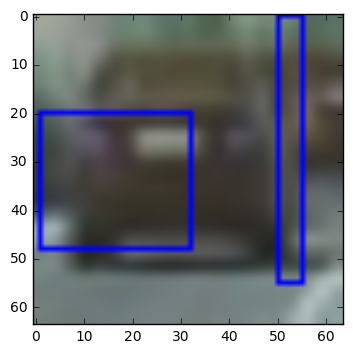

In [9]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=1):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
plt.imshow(draw_boxes(cars[0],[((1,20),(32,48)),((55,55),(50,0))], color=(0, 0, 255), thick=1))

In [10]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
        # Calculate each window position
        # Append window position to list
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

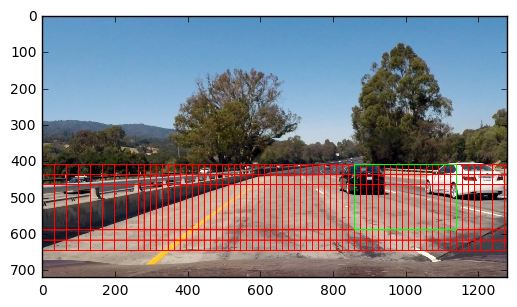

In [11]:
image = test_images[0]
windows0 = slide_window(image, x_start_stop=[None, None], y_start_stop=[410, 540], 
                    xy_window=(280, 180), xy_overlap=(0.88, 0.84))
                       
window_img = draw_boxes(image, windows0, color=(0, 0, 255), thick=2) 
window_img = draw_boxes(window_img, windows0[26:27], color=(0, 255,0), thick=2) 
plt.imshow(cv2.cvtColor(window_img,cv2.COLOR_BGR2RGB))

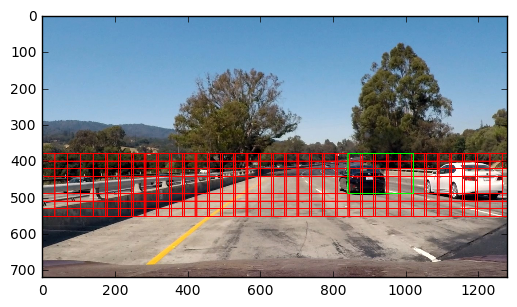

In [12]:
image = test_images[0]
windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=[380, 500], 
                    xy_window=(180, 110), xy_overlap=(0.8, 0.8))
                       
window_img = draw_boxes(image, windows1, color=(0, 0, 255), thick=2) 
window_img = draw_boxes(window_img, windows1[24:25], color=(0, 255,0), thick=2) 
plt.imshow(cv2.cvtColor(window_img,cv2.COLOR_BGR2RGB))

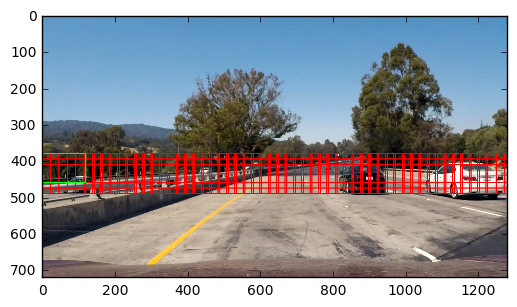

In [13]:
windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=[380, 450], 
                    xy_window=(120, 80), xy_overlap=(0.8, 0.8))
                       
window_img = draw_boxes(image, windows2, color=(0, 0, 255), thick=2)  
window_img = draw_boxes(window_img, windows2[0:1], color=(0, 255,0), thick=2)
plt.imshow(cv2.cvtColor(window_img,cv2.COLOR_BGR2RGB))

In [14]:
#Append all windows into one
windows = []
windows = windows0 + windows1 + windows2

In [41]:
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[350, image.shape[0]-100], 
                    xy_window=(96, 96), xy_overlap=(0.80, 0.80))

In [15]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
        elif hog_channel == 'gray':
            hog_features = get_hog_features(cv2.cvtColor(feature_image,cv2.COLOR_BGR2GRAY), orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)
img = test_images[0]
feat = single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=False)

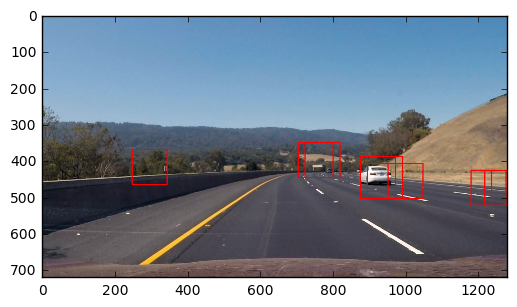

In [77]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1,-1).astype(np.float64)) 
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

image = test_images[2]
draw_image = np.copy(image)
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16   # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=2)                    

plt.imshow(cv2.cvtColor(window_img,cv2.COLOR_BGR2RGB))

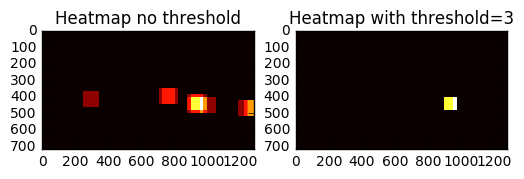

In [78]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, boxlist):
    # Iterate through list of bboxes
    for box in boxlist:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

heatmap = add_heat(heat,hot_windows)
plt.subplot(121)
plt.imshow(heatmap,cmap='hot')
plt.title('Heatmap no threshold')
threshold = 3
heatmap = apply_threshold(heatmap,threshold)
plt.subplot(122)
plt.imshow(heatmap,cmap='hot')
plt.title('Heatmap with threshold=3')


1 cars found


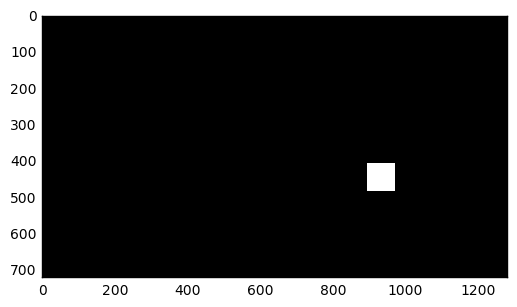

In [79]:
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

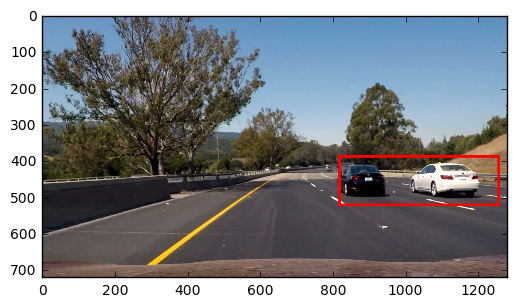

In [66]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    noise_red = 50
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        #reduce noise
        if ((np.abs(bbox[0][0]-bbox[1][0])>noise_red) & (np.abs(bbox[0][1]-bbox[1][1])>noise_red)) :
        # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(image), labels)
# Display the image
plt.imshow(cv2.cvtColor(draw_img,cv2.COLOR_BGR2RGB))

(228, 350)


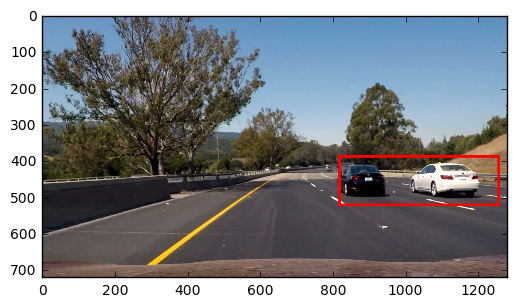

In [55]:
###Define a heatmap pipeline that removes false positives and extra boxes
def heat_map_pipeline(image,windows):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heat,windows)
    threshold = 3
    heatmap = apply_threshold(heatmap, threshold)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img
plt.imshow(cv2.cvtColor(heat_map_pipeline(image,hot_windows),cv2.COLOR_BGR2RGB))
print(hot_windows[0][0])

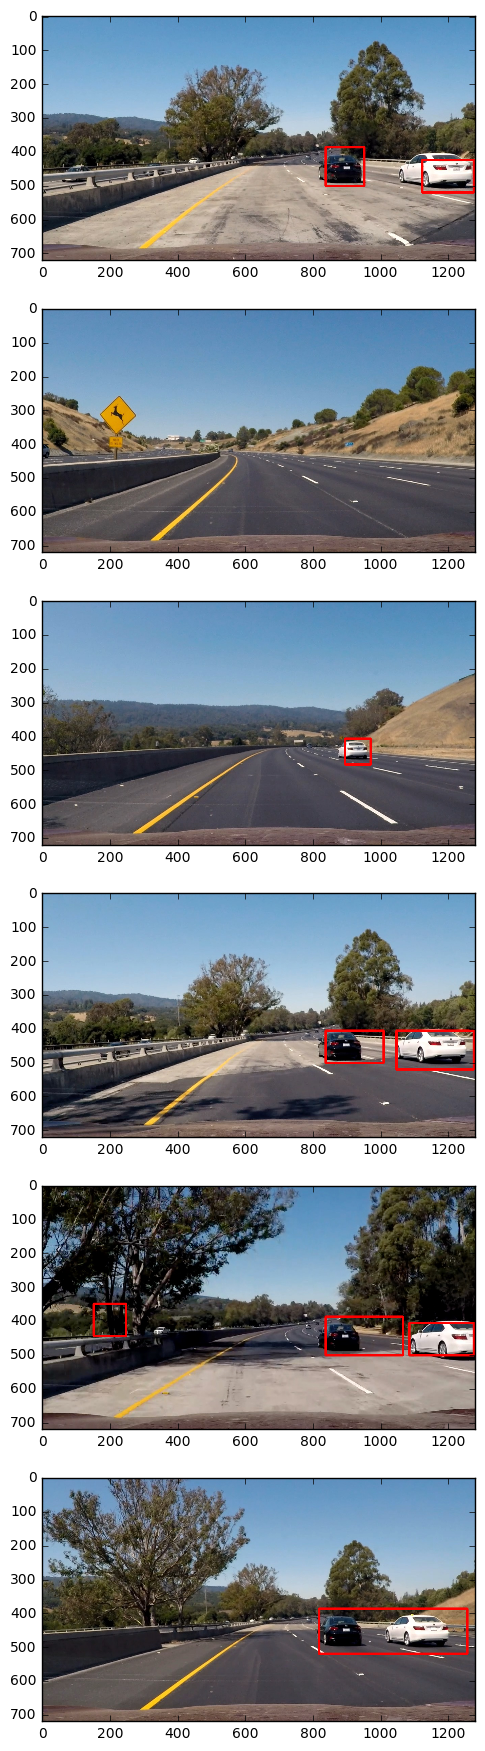

In [69]:
###Define a pipeline for the whole algorithm
def pipeline(image):
    draw_image = np.copy(image)
    color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat) 
    
    
    final = heat_map_pipeline(draw_image,hot_windows)
    return final
#i = 0
fig = plt.figure(figsize=(22,22))
for i  in range(len(test_images)):
    plt.subplot(len(test_images),1,i+1)
    plt.imshow(cv2.cvtColor(pipeline(test_images[i]),cv2.COLOR_BGR2RGB))
    plt.savefig('CarND-Vehicle-Detection-master/output_images/test' + str(i+1) + 'output.jpg')

In [23]:
###VIDEO
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [52]:
video_output = 'CarND-Vehicle-Detection-master/test_video_output.mp4'
clip1 = VideoFileClip("CarND-Vehicle-Detection-master/test_video.mp4")
video_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video CarND-Vehicle-Detection-master/test_video_output.mp4
[MoviePy] Writing video CarND-Vehicle-Detection-master/test_video_output.mp4


 97%|████████████████████████████████████████▉ | 38/39 [04:18<00:06,  6.68s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: CarND-Vehicle-Detection-master/test_video_output.mp4 

Wall time: 4min 20s


In [58]:
project_video_output = 'CarND-Vehicle-Detection-master/project_video_output.mp4'
clip1 = VideoFileClip("CarND-Vehicle-Detection-master/project_video.mp4")
project_video_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video CarND-Vehicle-Detection-master/project_video_output.mp4
[MoviePy] Writing video CarND-Vehicle-Detection-master/project_video_output.mp4


100%|███████████████████████████████████▉| 1260/1261 [2:33:48<00:07,  7.87s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: CarND-Vehicle-Detection-master/project_video_output.mp4 

Wall time: 2h 33min 51s
